<a href="https://colab.research.google.com/github/tzhsu211/CVS/blob/main/Validation0227.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.6 MB/s eta 0:00:00


In [2]:
import torch
import warnings
import numpy as np
import pandas as pd
from datasets import Dataset
from matplotlib import pyplot as plt
from transformers import BertTokenizerFast, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, BertConfig
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.auto import tqdm

In [3]:
torch.cuda.is_available()

True

In [4]:
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('./cvs_products.csv')

In [6]:
df.head()

,product,link,store,CVS,rating,review
0,德式香腸小土司/35元(搭飲料49元) (試吃試用請標註0元),https://www.ptt.cc/bbs/CVS/M.1431113906.A.069....,全家,全家,75,似乎是前幾天新上市的? 麵包本身跟之前小土司系列一樣，但裡面沒包任何料 德式香腸雖然小小一條...
1,古早新竹肉燥炊粉 50元 / 小滷Q豬腳 38元 (搭貼標30元),https://www.ptt.cc/bbs/CVS/M.1431239015.A.8BF....,全家 / 晉欣食品 / 欣光食品,全家,60,炊粉把包裝拆開的時候滿香的，中間有些許肉燥和一些高麗菜 拌勻後吃起來有點太鹹，味道則是普普通...
2,Pocky 午後紅茶 卡士達口味(99元),https://www.ptt.cc/bbs/CVS/M.1431258488.A.442....,7-11,7-11,98,一口咬下 哇，好吃啊！！ 我從沒吃過這麼好吃的餅乾， 救命啊~~~ 卡士達的醬汁鎮在纖維裡面...
3,御料理-牛肉乾拌麵 90元,https://www.ptt.cc/bbs/CVS/M.1431263519.A.251....,7-11,7-11,85,麵體是使用好勁道龍捲麵 剛好對我的味 吃乾麵最喜歡這種寬扁型的麵條 而且口感還算滿Q滿有嚼勁...
4,韓式泡菜涼麵 原價55元 特價33,https://www.ptt.cc/bbs/CVS/M.1431274326.A.AEE....,萊爾富,萊爾富,90,照片 沒貼標還想說這麼貴的商品應該不會特價33吧 連7-11一律39元只看到基本款跟大份量涼...


In [7]:
scaler = StandardScaler()
df['standard_rating'] = scaler.fit_transform(df['rating'].values.reshape(-1,1))
df.head()

,product,link,store,CVS,rating,review,standard_rating
0,德式香腸小土司/35元(搭飲料49元) (試吃試用請標註0元),https://www.ptt.cc/bbs/CVS/M.1431113906.A.069....,全家,全家,75,似乎是前幾天新上市的? 麵包本身跟之前小土司系列一樣，但裡面沒包任何料 德式香腸雖然小小一條...,-0.104011
1,古早新竹肉燥炊粉 50元 / 小滷Q豬腳 38元 (搭貼標30元),https://www.ptt.cc/bbs/CVS/M.1431239015.A.8BF....,全家 / 晉欣食品 / 欣光食品,全家,60,炊粉把包裝拆開的時候滿香的，中間有些許肉燥和一些高麗菜 拌勻後吃起來有點太鹹，味道則是普普通...,-1.114129
2,Pocky 午後紅茶 卡士達口味(99元),https://www.ptt.cc/bbs/CVS/M.1431258488.A.442....,7-11,7-11,98,一口咬下 哇，好吃啊！！ 我從沒吃過這麼好吃的餅乾， 救命啊~~~ 卡士達的醬汁鎮在纖維裡面...,1.444837
3,御料理-牛肉乾拌麵 90元,https://www.ptt.cc/bbs/CVS/M.1431263519.A.251....,7-11,7-11,85,麵體是使用好勁道龍捲麵 剛好對我的味 吃乾麵最喜歡這種寬扁型的麵條 而且口感還算滿Q滿有嚼勁...,0.569401
4,韓式泡菜涼麵 原價55元 特價33,https://www.ptt.cc/bbs/CVS/M.1431274326.A.AEE....,萊爾富,萊爾富,90,照片 沒貼標還想說這麼貴的商品應該不會特價33吧 連7-11一律39元只看到基本款跟大份量涼...,0.906107


In [8]:
 X_train, X_test, y_train, y_test = train_test_split(df['review'], df['standard_rating'], test_size=0.1, random_state=42)

In [9]:
len(X_train), len(X_test)

(15600, 1734)

In [10]:
train_df = pd.DataFrame({'text': X_train, 'label': y_train.astype(float)})
test_df = pd.DataFrame({'text': X_test, 'label': y_test.astype(float)})

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [11]:
def round5(x) -> int:
  '''
  This function rounds the given number to the nearest multiple of 5.
  When reviewing the data, I found that most of the ratings are in increments of 5 (i.e., multiples of 5).
  Therefore, this function rounds the input to the nearest multiple of 5 to better fit the data distribution.
  '''
  return np.round(x / 5) * 5

In [12]:
test_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 1734
})

In [13]:
check_point_pth = './google_bert'
model_bert_base = AutoModelForSequenceClassification.from_pretrained(check_point_pth, config = './google_bert/config.json')
model_bert_base.to('cuda')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [14]:
model_bert_base.eval()
y_preds_round = []
y_preds = []
tokenizer = BertTokenizerFast.from_pretrained('google-bert/bert-base-chinese')

for text in tqdm(test_dataset['text']):
  inputs = tokenizer(text, max_length = 256, truncation= True, padding= True, return_tensors='pt')
  inputs.to('cuda')

  with torch.no_grad():
    outputs= model_bert_base(**inputs)

  logits = outputs.logits.squeeze().cpu().numpy()
  y_pred = scaler.inverse_transform(logits.reshape(-1,1))

  y_pred_round = round5(y_pred)
  y_preds_round.append(y_pred_round)
  y_preds.append(y_pred)

y_preds_round = np.array(y_preds_round).squeeze()
y_preds = np.array(y_preds).squeeze()


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

  0%|          | 0/1734 [00:00<?, ?it/s]

In [15]:
y_test = scaler.inverse_transform(y_test.values.reshape(-1, 1)).squeeze()
y_test[:5]

array([70., 80., 70., 80., 80.])

In [16]:
mse_unrounded = mean_squared_error(y_test, y_preds)
r2_unrounded = r2_score(y_test, y_preds)

mse_rounded = mean_squared_error(y_test, y_preds_round)
r2_rounded = r2_score(y_test, y_preds_round)

print(f"未四捨五入的 MSE: {mse_unrounded}, R2: {r2_unrounded}")
print(f"四捨五入的 MSE: {mse_rounded}, R2: {r2_rounded}")

未四捨五入的 MSE: 82.25305875000154, R2: 0.6513710287185501
四捨五入的 MSE: 85.56401384083046, R2: 0.6373375704518721


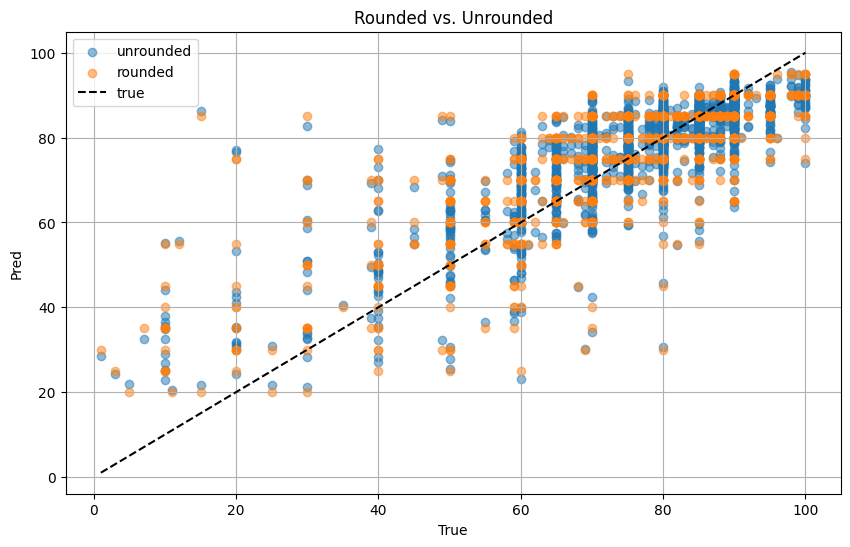

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_preds, label='unrounded', alpha=0.5)
plt.scatter(y_test, y_preds_round, label='rounded', alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'k--', label="true")
plt.xlabel('True')
plt.ylabel('Pred')
plt.title('Rounded vs. Unrounded')
plt.legend()
plt.grid(True)
plt.show()

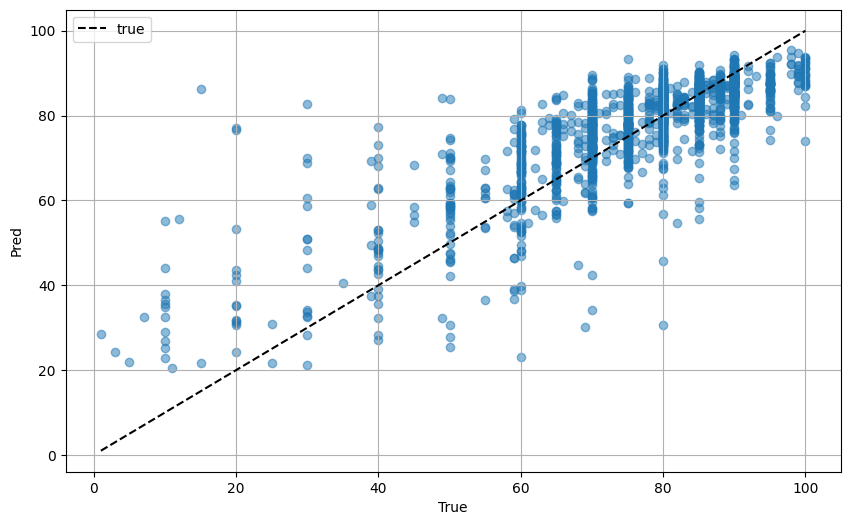

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'k--', label="true")
plt.xlabel('True')
plt.ylabel('Pred')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
differences = np.abs(y_preds - y_test)
differences

array([3.02931213, 5.30043793, 7.72441101, ..., 5.73788452, 5.23548889,
       7.76850891])

In [21]:
y_preds[:10]

array([73.02931 , 85.30044 , 77.72441 , 86.171295, 76.76916 , 81.99333 ,
       74.03679 , 79.78701 , 86.30046 , 79.48806 ], dtype=float32)

In [22]:
top_5_indices = np.argsort(differences)[-5:][::-1]

In [23]:
top_5_indices

array([1022, 1581,  224, 1183, 1583])

In [28]:
for i in top_5_indices:
  print(y_preds[i])
  print(y_test[i])
  print(test_dataset['text'][i])


86.15839
15.0
這兩樣的味道都很奇妙 乳加有類似草莓果粒的樣子 很甜 大波露更不好吃 雖然知道不可能是真的草莓 但化工味有點噁心 有興趣的人可以去買來試試看 滋露巧克力 一盒有四個 做得很精緻 缺點是包裝多 不太環保 而且我這兩盒同一種口味有不同的包裝 第一個是咖啡巧克力 方形的巧克力咬下去中間像咖啡牛嘎糖？ 很好吃 第二個是草莓巧克力 圖案很漂亮～ 咬下去是草莓夾心 草莓味不像上面兩樣吃起來會覺得? 第三個是牛奶巧克力 中間是牛奶夾心 （草莓口味剖面） 最後一個咬下去中間夾餅乾～～最喜歡這個 很好吃！！ 巧克力脆餅的概念 滋露巧克力真的很好吃～！推推 ( 違者逕行處分)
77.18606
20.0
今天忽然很想吃壽司，可是帶小孩出門去壽司店有點麻煩，最後將就推去711吃手卷…… 印象中這商品存在好久了，我都吃藍色包裝的（海鮮口味嗎？），但今天架上沒有，只好 拿橘色招牌。 一咬下去，飯超級無敵乾硬的……！！！後來想說，莫非是在店內放太久放到乾掉？趕緊 翻背面看有效期限，果然是今天到期（可是它昨天才製造耶。覺得困惑？）。如果製造當 天來買，不知道飯的狀況會不會好一點？ 至於味道，蛋沙拉那個有點鹹。好像還是藍色包裝的口味好一些。 不能浪費食物，所以最後還是通通吃完！幸好我還有買一包洋芋片，本來想要當宵夜的， 但吃完手卷的當下就忍不住開來吃，撫慰一下小小受傷心靈。
76.56762
20.0
不囉嗦直接上圖！ 看版友說像純粹喝就很安心的買了，還順手帶了同系列咖啡！ 為了讓大家看清楚內容物還拿了紅酒杯裝......一看這色澤就抖了一下，入口更是可怕！！！！小時候哪有這種鬼味道啊！！！！！！！(小時後的回憶一直是麥香系列 XD） 為了要再用同個杯子拍咖啡，只好硬著頭皮喝完...... 好！很明顯和奶茶沒什麼差別（絕對不是偷懶發同張圖，看泡泡不一樣哦），帶著忐忑不安的心淺嚐一口，咦咦咦咦咦還不錯耶！ 再喝一口，哦是不那麼甜的咖啡廣場味，還可接受，也可能是剛嚐完地獄奶茶後味覺失去辨識能力。 一早喝完兩杯過甜飲料已鎖喉......
82.79492
30.0
要先說以前沒有吃過類似的三明治（最常吃的是起司三重奏和焗烤鮪魚玉米），所以沒想 到這個會辣，因為本來就不吃辣，所以這點讓我的主觀分數變差不少 首先來看看剖面圖 以7-11來說應該算是還不錯了吧（？） 另一邊的肉差不